#Project Setup

In [1]:
!pip -q install transformers datasets torch scikit-learn tqdm sentence-transformers

In [2]:
import pandas as pd

# Helpers

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

def evaluate_model(y, y_pred, data_set_name = ""):
  accuracy = accuracy_score(y, y_pred)
  precision = precision_score(y, y_pred)
  recall = recall_score(y, y_pred)
  f1 = f1_score(y, y_pred)
  roc_auc = roc_auc_score(y, y_pred)
  conf_matrix = confusion_matrix(y, y_pred, normalize="true")

  print(f"{data_set_name} Accuracy:", accuracy)
  print(f"{data_set_name} Precision:", precision)
  print(f"{data_set_name} Recall:", recall)
  print(f"{data_set_name} F1 Score:", f1)
  print(f"{data_set_name} ROC AUC Score:", roc_auc)

  conf_matrix = conf_matrix * 100
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Not Duplicate", "Duplicate"], yticklabels=["Not Duplicate", "Duplicate"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()


def plot_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()


In [4]:
def clean_gpu():
  import gc
  import torch
  gc.collect()
  torch.cuda.empty_cache()

#Data Loading and Analysis

In [5]:
train_df = pd.read_csv("./quora_question_pairs_train_.csv")
test_df = pd.read_csv("./quora_question_pairs_test.csv")

In [6]:
test_df

,id,qid1,qid2,question1,question2,is_duplicate
0,305985,429434,429435,Why is beef banned in India and not pork as well?,Is beef banned in india?,0
1,5193,10230,10231,At what valuation did Homejoy raise money in D...,Should a wealthy founder self-fund his second ...,0
2,123326,199422,199423,How do we judge?,How do I judge my love?,0
3,368557,327674,498931,Are Adderall and meth the same?,Are concerta and meth test the same?,0
4,369226,499645,499646,If you had internet access to only one site fo...,Why is there .co.uk for British internet sites...,0
...,...,...,...,...,...,...
80853,92978,4034,155551,How do I unpop a clogged ear?,What causes ears to become clogged?,0
80854,156081,192114,244370,"Why does life have to be fair and just, or why...",Why can't life be fair?,0
80855,237304,119423,348442,What is the method to calculate atomic mass?,How can we calculate atomic mass?,1
80856,191024,4776,117835,What is the true health status of TamilNadu CM...,What is the health condition of Tamilnadu CM J...,1


In [7]:
train_df

,id,qid1,qid2,question1,question2,is_duplicate
0,332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three indepen...,0
1,196656,297402,297403,What is practical management and what is strat...,What are the practical aspects of strategic ma...,0
2,113125,184949,184950,How useful is MakeUseOf Answers?,Is there any Q&A site that is not Yahoo answer...,0
3,266232,101283,163744,Which is the best place to reside in India and...,Which ia the best place to visit in India?,0
4,122738,17811,27517,Why do so many people ask questions on Quora t...,Why don't many people posting questions on Quo...,1
...,...,...,...,...,...,...
323427,111701,182893,182894,What are the major stereotypes people have abo...,What are the major stereotypes people have abo...,0
323428,90934,152504,152505,What are some of the best and most creative pr...,Which is one of the worst and most insensible ...,0
323429,363857,493887,493888,Why is there a road named Aurangzeb in Delhi?,How do you justify naming a road after Aurangzeb?,0
323430,29409,54414,54415,What are the tips given to a teacher to satisf...,Can a high school teacher legally force studen...,0


In [8]:
train_df.isna().sum()

,0
id,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


In [9]:
test_df.isna().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [10]:
train_df.dropna(inplace=True)

train_df.isna().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [29]:
train_df.duplicated().sum()

0

In [57]:
train_df["is_duplicate"].value_counts(normalize=True) * 100

,proportion
is_duplicate,
0,63.079996
1,36.920004


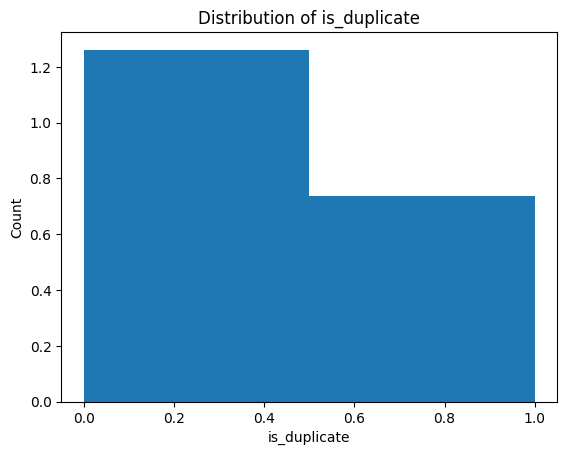

In [54]:
plt.hist(train_df["is_duplicate"], bins=2, density=True)
plt.xlabel("is_duplicate")
plt.ylabel("Count")
plt.title("Distribution of is_duplicate")
plt.show()

### Simple Similarity Check

In this section, we explore the simplest approach for question similarity detection. The idea is straightforward: we generate vectors for each sentence and compute the distance between these vectors. If the distance exceeds a certain decision boundary, we classify them as *different* questions; if it's below the threshold, we label them as *the same*.

While this method may not capture the full depth of semantic meaning—often generalizing too broadly—it can still be surprisingly effective for many datasets, especially when speed and simplicity are priorities.

For this implementation, I've utilized **Cosine Similarity** as the distance metric. However, other distance measures could yield comparably similar results with slight variations.

In [28]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

# Initialize the model
encoder_model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to encode sentences in batches
def batch_encode(sentences, batch_size=10000):
    iter = 0
    embeddings = []
    print(len(sentences))
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        batch_embeddings = encoder_model.encode(batch, convert_to_tensor=True)
        embeddings.extend(batch_embeddings.cpu().numpy())
        iter += batch_size

        if iter % batch_size * 10 == 0:
            print((iter / len(sentences)) * 100)
    return np.array(embeddings)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [11]:
# Encode question1 and question2 in batches
question1_embedding = batch_encode(train_df["question1"].tolist())
question2_embedding = batch_encode(train_df["question2"].tolist())

323429
3.091868694520281
6.183737389040562
9.275606083560843
12.367474778081124
15.459343472601406
18.551212167121687
21.643080861641966
24.73494955616225
27.82681825068253
30.91868694520281
34.010555639723094
37.10242433424337
40.19429302876365
43.28616172328393
46.37803041780422
49.4698991123245
52.561767806844784
55.65363650136506
58.745505195885336
61.83737389040562
64.9292425849259
68.02111127944619
71.11297997396646
74.20484866848675
77.29671736300703
80.3885860575273
83.48045475204759
86.57232344656786
89.66419214108815
92.75606083560844
95.84792953012872
98.939798224649
102.03166691916927
323429
3.091868694520281
6.183737389040562
9.275606083560843
12.367474778081124
15.459343472601406
18.551212167121687
21.643080861641966
24.73494955616225
27.82681825068253
30.91868694520281
34.010555639723094
37.10242433424337
40.19429302876365
43.28616172328393
46.37803041780422
49.4698991123245
52.561767806844784
55.65363650136506
58.745505195885336
61.83737389040562
64.9292425849259
68.021

In [12]:
train_df["question1_embedding"] = question1_embedding.tolist()

In [13]:
train_df["question2_embedding"] = question2_embedding.tolist()

In [14]:
test_question1_embedding = batch_encode(test_df["question1"].tolist())
test_question2_embedding = batch_encode(test_df["question2"].tolist())

test_df["question1_embedding"] = test_question1_embedding.tolist()
test_df["question2_embedding"] = test_question2_embedding.tolist()

80858
12.367360063320884
24.73472012664177
37.10208018996265
49.46944025328354
61.83680031660441
74.2041603799253
86.57152044324619
98.93888050656707
111.30624056988796
80858
12.367360063320884
24.73472012664177
37.10208018996265
49.46944025328354
61.83680031660441
74.2041603799253
86.57152044324619
98.93888050656707
111.30624056988796


In [15]:
i = 0
def cosine_similarity(vector1, vector2):
    global i
    i += 1
    if i % 10000 == 0:
        print(i)
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity

train_df["similarity"] = train_df.apply(lambda row: cosine_similarity(row["question1_embedding"], row["question2_embedding"]), axis=1)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000


In [18]:
test_df["similarity"] = test_df.apply(lambda row: cosine_similarity(row["question1_embedding"], row["question2_embedding"]), axis=1)

330000
340000
350000
360000
370000
380000
390000
400000


In [19]:
threshold = train_df[train_df["is_duplicate"] == 1]["similarity"].mean()
train_df["prediction"] = (train_df["similarity"] >= threshold).astype(int)
test_df["prediction"] = (test_df["similarity"] >= threshold).astype(int)

Train Accuracy: 0.7684437697299871
Train Precision: 0.7470093437201767
Train Recall: 0.5637383803701532
Train F1 Score: 0.6425612340352418
Train ROC AUC Score: 0.7259969429924131


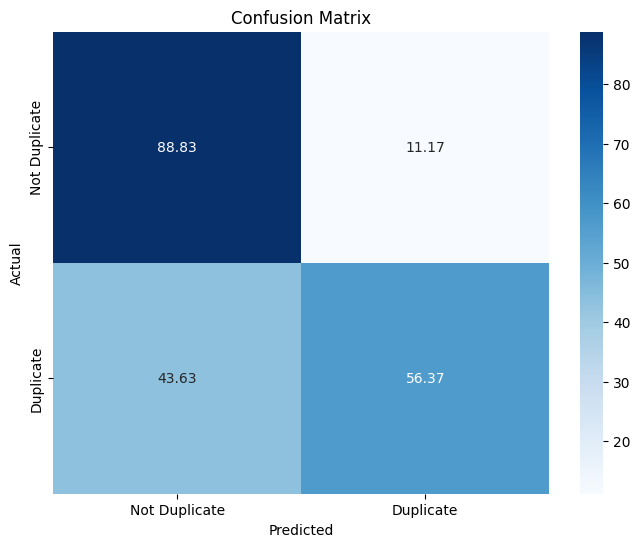

Test Accuracy: 0.7689777140171659
Test Precision: 0.7469607886477168
Test Recall: 0.5660067664891301
Test F1 Score: 0.6440141784502801
Test ROC AUC Score: 0.726891237376513


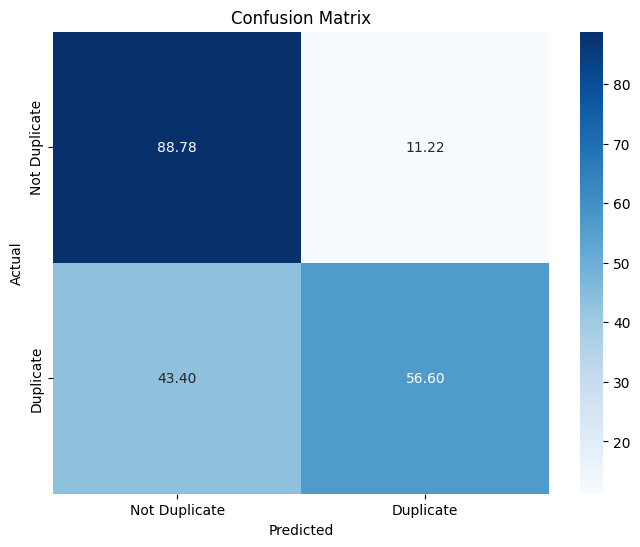

In [21]:
evaluate_model(train_df["is_duplicate"], train_df["prediction"], "Train")
evaluate_model(test_df["is_duplicate"], test_df["prediction"], "Test")

### XGBoost Model

In this section, we take a more sophisticated approach to question similarity detection using **XGBoost**, a powerful gradient boosting algorithm. Here, we provide the model with vectors for both questions as inputs, allowing it to analyze how each feature of these vectors relates to one another. The goal is for the model to learn patterns and relationships that distinguish between similar and different questions.

Because **gradient boosting models** excel at identifying non-linear patterns, this approach can significantly enhance our ability to differentiate between questions compared to simpler methods. The added complexity of XGBoost allows us to capture nuanced relationships in the data, resulting in more accurate classifications.

In [22]:
import xgboost as xgb

train_question1_embedding = np.array(train_df["question1_embedding"].tolist())
train_question2_embedding = np.array(train_df["question2_embedding"].tolist())
train_combined_embeddings = np.concatenate((question1_embedding, question2_embedding), axis=1)

test_question1_embedding = np.array(test_df["question1_embedding"].tolist())
test_question2_embedding = np.array(test_df["question2_embedding"].tolist())
test_combined_embeddings = np.concatenate((test_question1_embedding, test_question2_embedding), axis=1)

X_train = train_combined_embeddings
y_train = train_df["is_duplicate"]

X_test = test_combined_embeddings
y_test = test_df["is_duplicate"]

In [23]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'test')]

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'auc'
params['eta'] = 0.02
params['max_depth'] = 4
params["device"] = "cuda"

bst = xgb.train(params, d_train, 9000, watchlist, early_stopping_rounds=50, verbose_eval=10)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-auc:0.65908	valid-auc:0.66028
[10]	train-auc:0.68297	valid-auc:0.68256
[20]	train-auc:0.70085	valid-auc:0.69956
[30]	train-auc:0.71376	valid-auc:0.71206
[40]	train-auc:0.72461	valid-auc:0.72255
[50]	train-auc:0.74037	valid-auc:0.73761
[60]	train-auc:0.75859	valid-auc:0.75536
[70]	train-auc:0.77199	valid-auc:0.76847
[80]	train-auc:0.78443	valid-auc:0.78054
[90]	train-auc:0.79430	valid-auc:0.79030
[100]	train-auc:0.80388	valid-auc:0.79981
[110]	train-auc:0.81235	valid-auc:0.80816
[120]	train-auc:0.81910	valid-auc:0.81489
[130]	train-auc:0.82549	valid-auc:0.82118
[140]	train-auc:0.83152	valid-auc:0.82724
[150]	train-auc:0.83643	valid-auc:0.83215
[160]	train-auc:0.84100	valid-auc:0.83669
[170]	train-auc:0.84505	valid-auc:0.84076
[180]	train-auc:0.84868	valid-auc:0.84440
[190]	train-auc:0.85185	valid-auc:0.84757
[200]	train-auc:0.85480	valid-auc:0.85046
[210]	train-auc:0.85749	valid-auc:0.85312
[220]	train-auc:0.85998	valid-auc:0.85563
[230]	train-auc:0.86248	valid-auc:0.85816
[24

Train Accuracy: 0.9125866882685226
Train Precision: 0.8716217318262628
Train Recall: 0.8950674147893811
Train F1 Score: 0.8831889998016791
Train ROC AUC Score: 0.908953967272447


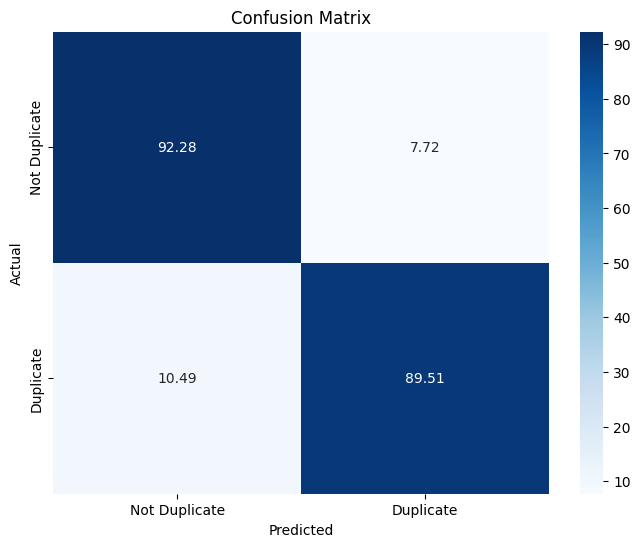

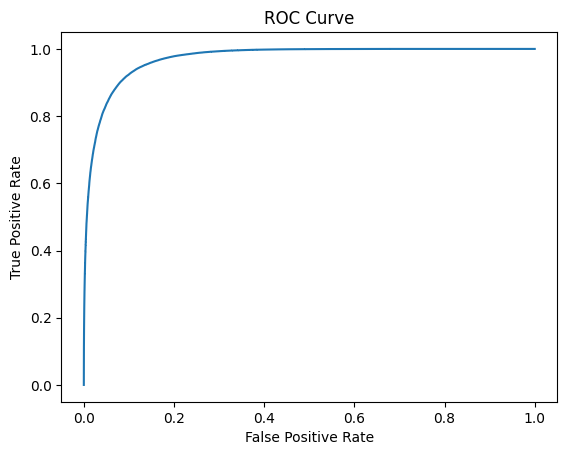

Test Accuracy: 0.8645774073066363
Test Precision: 0.8078564216149311
Test Recall: 0.8308042742772921
Test F1 Score: 0.8191696667437328
Test ROC AUC Score: 0.8575744731841317


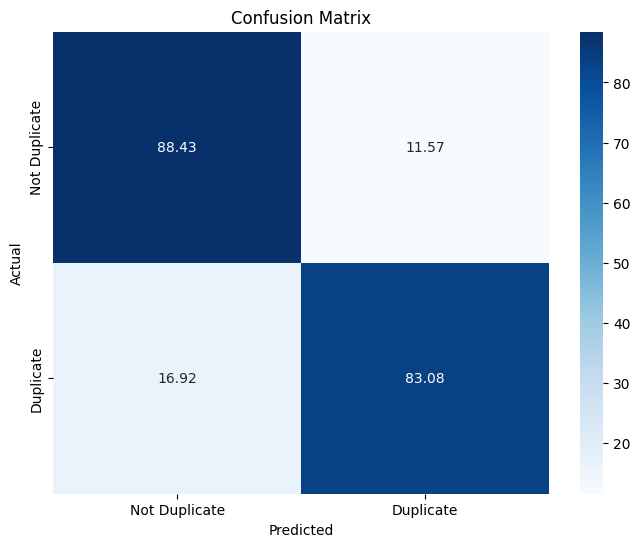

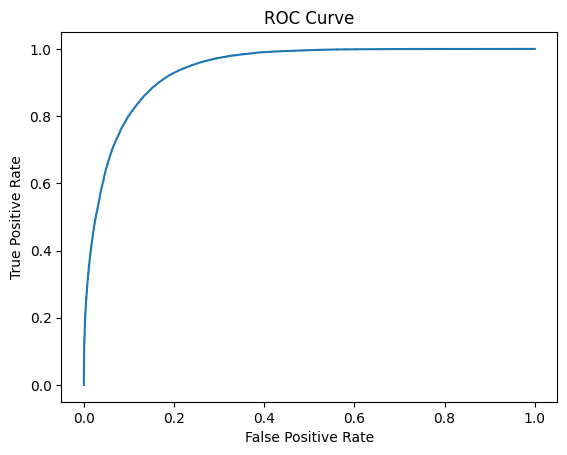

In [25]:
train_preds = bst.predict(d_train)
test_preds = bst.predict(d_test)

train_preds_label = (train_preds >= 0.5).astype(int)
test_preds_label = (test_preds >= 0.5).astype(int)

evaluate_model(y_train, train_preds_label, "Train")
plot_roc_curve(y_train, train_preds)
evaluate_model(y_test, test_preds_label, "Test")
plot_roc_curve(y_test, test_preds)


### BERT Fine-Tuning

In this section, we leverage the power of **BERT (Bidirectional Encoder Representations from Transformers)** to detect question similarity. BERT, a state-of-the-art transformer model, is pre-trained on a vast amount of text data to understand language contextually. By fine-tuning BERT on our specific dataset, we can tailor its deep contextual understanding to our task, enabling it to discern subtle semantic differences between questions.

For this approach, we feed the model pairs of questions and train it to classify whether they are the same or different. Unlike simpler models, BERT captures both the syntactic and semantic nuances of language, making it highly effective at identifying complex relationships between questions. Fine-tuning this model on our data allows us to harness its pre-trained knowledge while adapting it to our specific problem domain, resulting in significantly higher accuracy for challenging cases.

In [11]:
import pandas as pd
from datasets import Dataset

train_df['is_duplicate'] = train_df['is_duplicate'].astype(int)

# train_dataset_prep = train_df.drop(columns=["id", "qid1", "qid2", "question1_embedding", "question2_embedding", "similarity", "prediction"])
# test_dataset_prep = test_df.drop(columns=["id", "qid1", "qid2", "question1_embedding", "question2_embedding", "similarity", "prediction"])
train_dataset_prep = train_df.drop(columns=["id", "qid1", "qid2"])
test_dataset_prep = test_df.drop(columns=["id", "qid1", "qid2"])

concated_dataset_prep = pd.concat([train_dataset_prep, test_dataset_prep], ignore_index=True)

dataset = Dataset.from_pandas(concated_dataset_prep)
dataset = dataset.train_test_split(test_size=0.2)

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'is_duplicate'],
        num_rows: 323429
    })
    test: Dataset({
        features: ['question1', 'question2', 'is_duplicate'],
        num_rows: 80858
    })
})

In [13]:
from transformers import AutoTokenizer
import torch

model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Define a function to tokenize and prepare the dataset
def tokenize_function(examples):
    # Tokenize the sentences and include the 'labels' field
    tokenized = tokenizer(
        examples["question1"],
        examples["question2"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    tokenized["labels"] = examples["is_duplicate"]
    return tokenized

# Tokenize the dataset and include labels
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Ensure the labels are integers and in the correct format for PyTorch
tokenized_datasets = tokenized_datasets.map(lambda x: {"labels": torch.tensor(x["labels"], dtype=torch.long)})


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/323429 [00:00<?, ? examples/s]

Map:   0%|          | 0/80858 [00:00<?, ? examples/s]

Map:   0%|          | 0/323429 [00:00<?, ? examples/s]

Map:   0%|          | 0/80858 [00:00<?, ? examples/s]

In [14]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [15]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=350,
    per_device_eval_batch_size=350,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
print(tokenized_datasets["train"].features)

{'question1': Value(dtype='string', id=None), 'question2': Value(dtype='string', id=None), 'is_duplicate': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}


In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.286900,0.271636
2,0.230100,0.250197
3,0.197200,0.252269


TrainOutput(global_step=2775, training_loss=0.2561530431111654, metrics={'train_runtime': 4425.9754, 'train_samples_per_second': 219.226, 'train_steps_per_second': 0.627, 'total_flos': 6.382330914302208e+16, 'train_loss': 0.2561530431111654, 'epoch': 3.0})

In [20]:
trainer.save_model("fine_tuned_model")

1.2664176704840584
2.532835340968117
3.799253011452176
5.065670681936234
6.332088352420293
7.598506022904352
8.864923693388409
10.131341363872467
11.397759034356527
12.664176704840585
13.930594375324642
15.197012045808703
16.46342971629276
17.729847386776818
18.996265057260878
20.262682727744934
21.529100398228994
22.795518068713054
24.06193573919711
25.32835340968117
26.59477108016523
27.861188750649283
29.127606421133343
30.394024091617407
31.66044176210146
32.92685943258552
34.19327710306958
35.459694773553636
36.726112444037696
37.992530114521756
39.25894778500581
40.52536545548987
41.79178312597393
43.05820079645799
44.32461846694204
45.59103613742611
46.85745380791017
48.12387147839422
49.39028914887828
50.65670681936234
51.923124489846394
53.18954216033046
54.455959830814514
55.72237750129857
56.988795171782634
58.25521284226669
59.52163051275075
60.788048183234814
62.05446585371887
63.32088352420292
64.58730119468699
65.85371886517105
67.12013653565509
68.38655420613917
69.6529

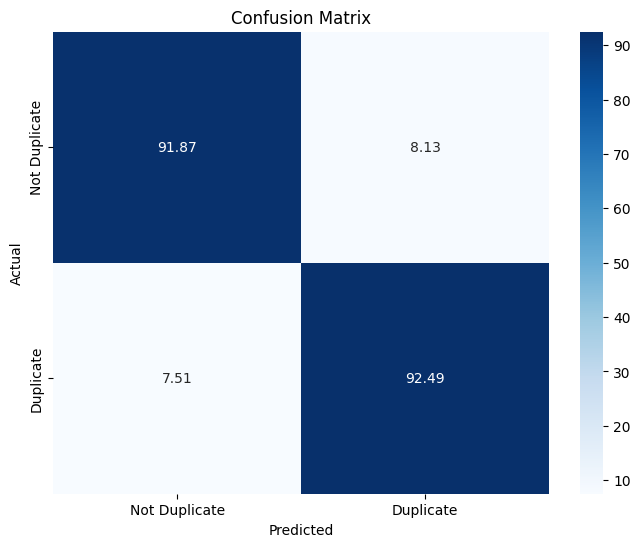

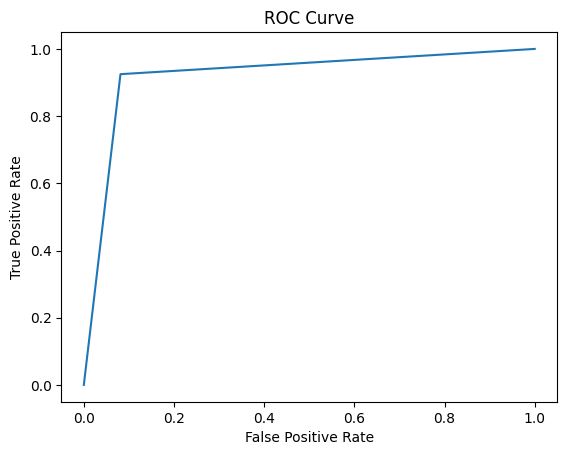

In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

def evaluate(model, tokenizer, test_df, batch_size=1024):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_labels = []

    iter = 0

    for i in range(0, len(test_df), batch_size):
        iter += batch_size
        if iter % batch_size * 10 == 0:
            print((iter / len(test_df)) * 100)
        batch = test_df.iloc[i:i + batch_size]
        inputs = tokenizer(
            batch["question1"].tolist(),
            batch["question2"].tolist(),
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        )
        inputs = {k: v.to('cuda') for k, v in inputs.items()} if torch.cuda.is_available() else inputs

        with torch.no_grad():
            outputs = model(**inputs)

        predictions = torch.argmax(outputs.logits, axis=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(batch["is_duplicate"].tolist())

    evaluate_model(all_labels, all_predictions, "Test")
    plot_roc_curve(all_labels, all_predictions)

# Usage
evaluate(model, tokenizer, test_df)
